<a href="https://colab.research.google.com/github/webdeeva/thinkful/blob/master/predicting_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment: predicting house prices**
Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: House Prices

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:
postgres_user = 'dsbc_student'

postgres_pw = '7*.8G9QH21'

postgres_host = '142.93.121.174'

postgres_port = '5432'

postgres_db = 'houseprices'


Please follow the example above and call engine.dispose() when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
Investigate the data, and do any necessary data cleaning.
Explore the data and find some variables that you think would be useful in predicting house prices.
Build your initial model using these features and estimate the parameters using OLS.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [0]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
house_prices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0

In [4]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
house_prices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Isolating datasets for non-numeric columns and numeric columns



In [6]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [7]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


### Missing Data

In [8]:
total_missing = house_prices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_prices_df.isnull().sum()/house_prices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


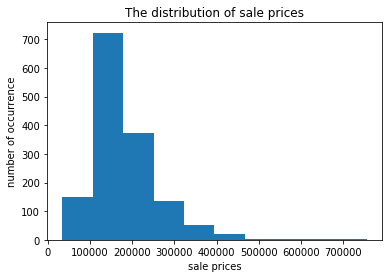

In [9]:

plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

**Sale Price is a non-normal distribution**

In [15]:
np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)


saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

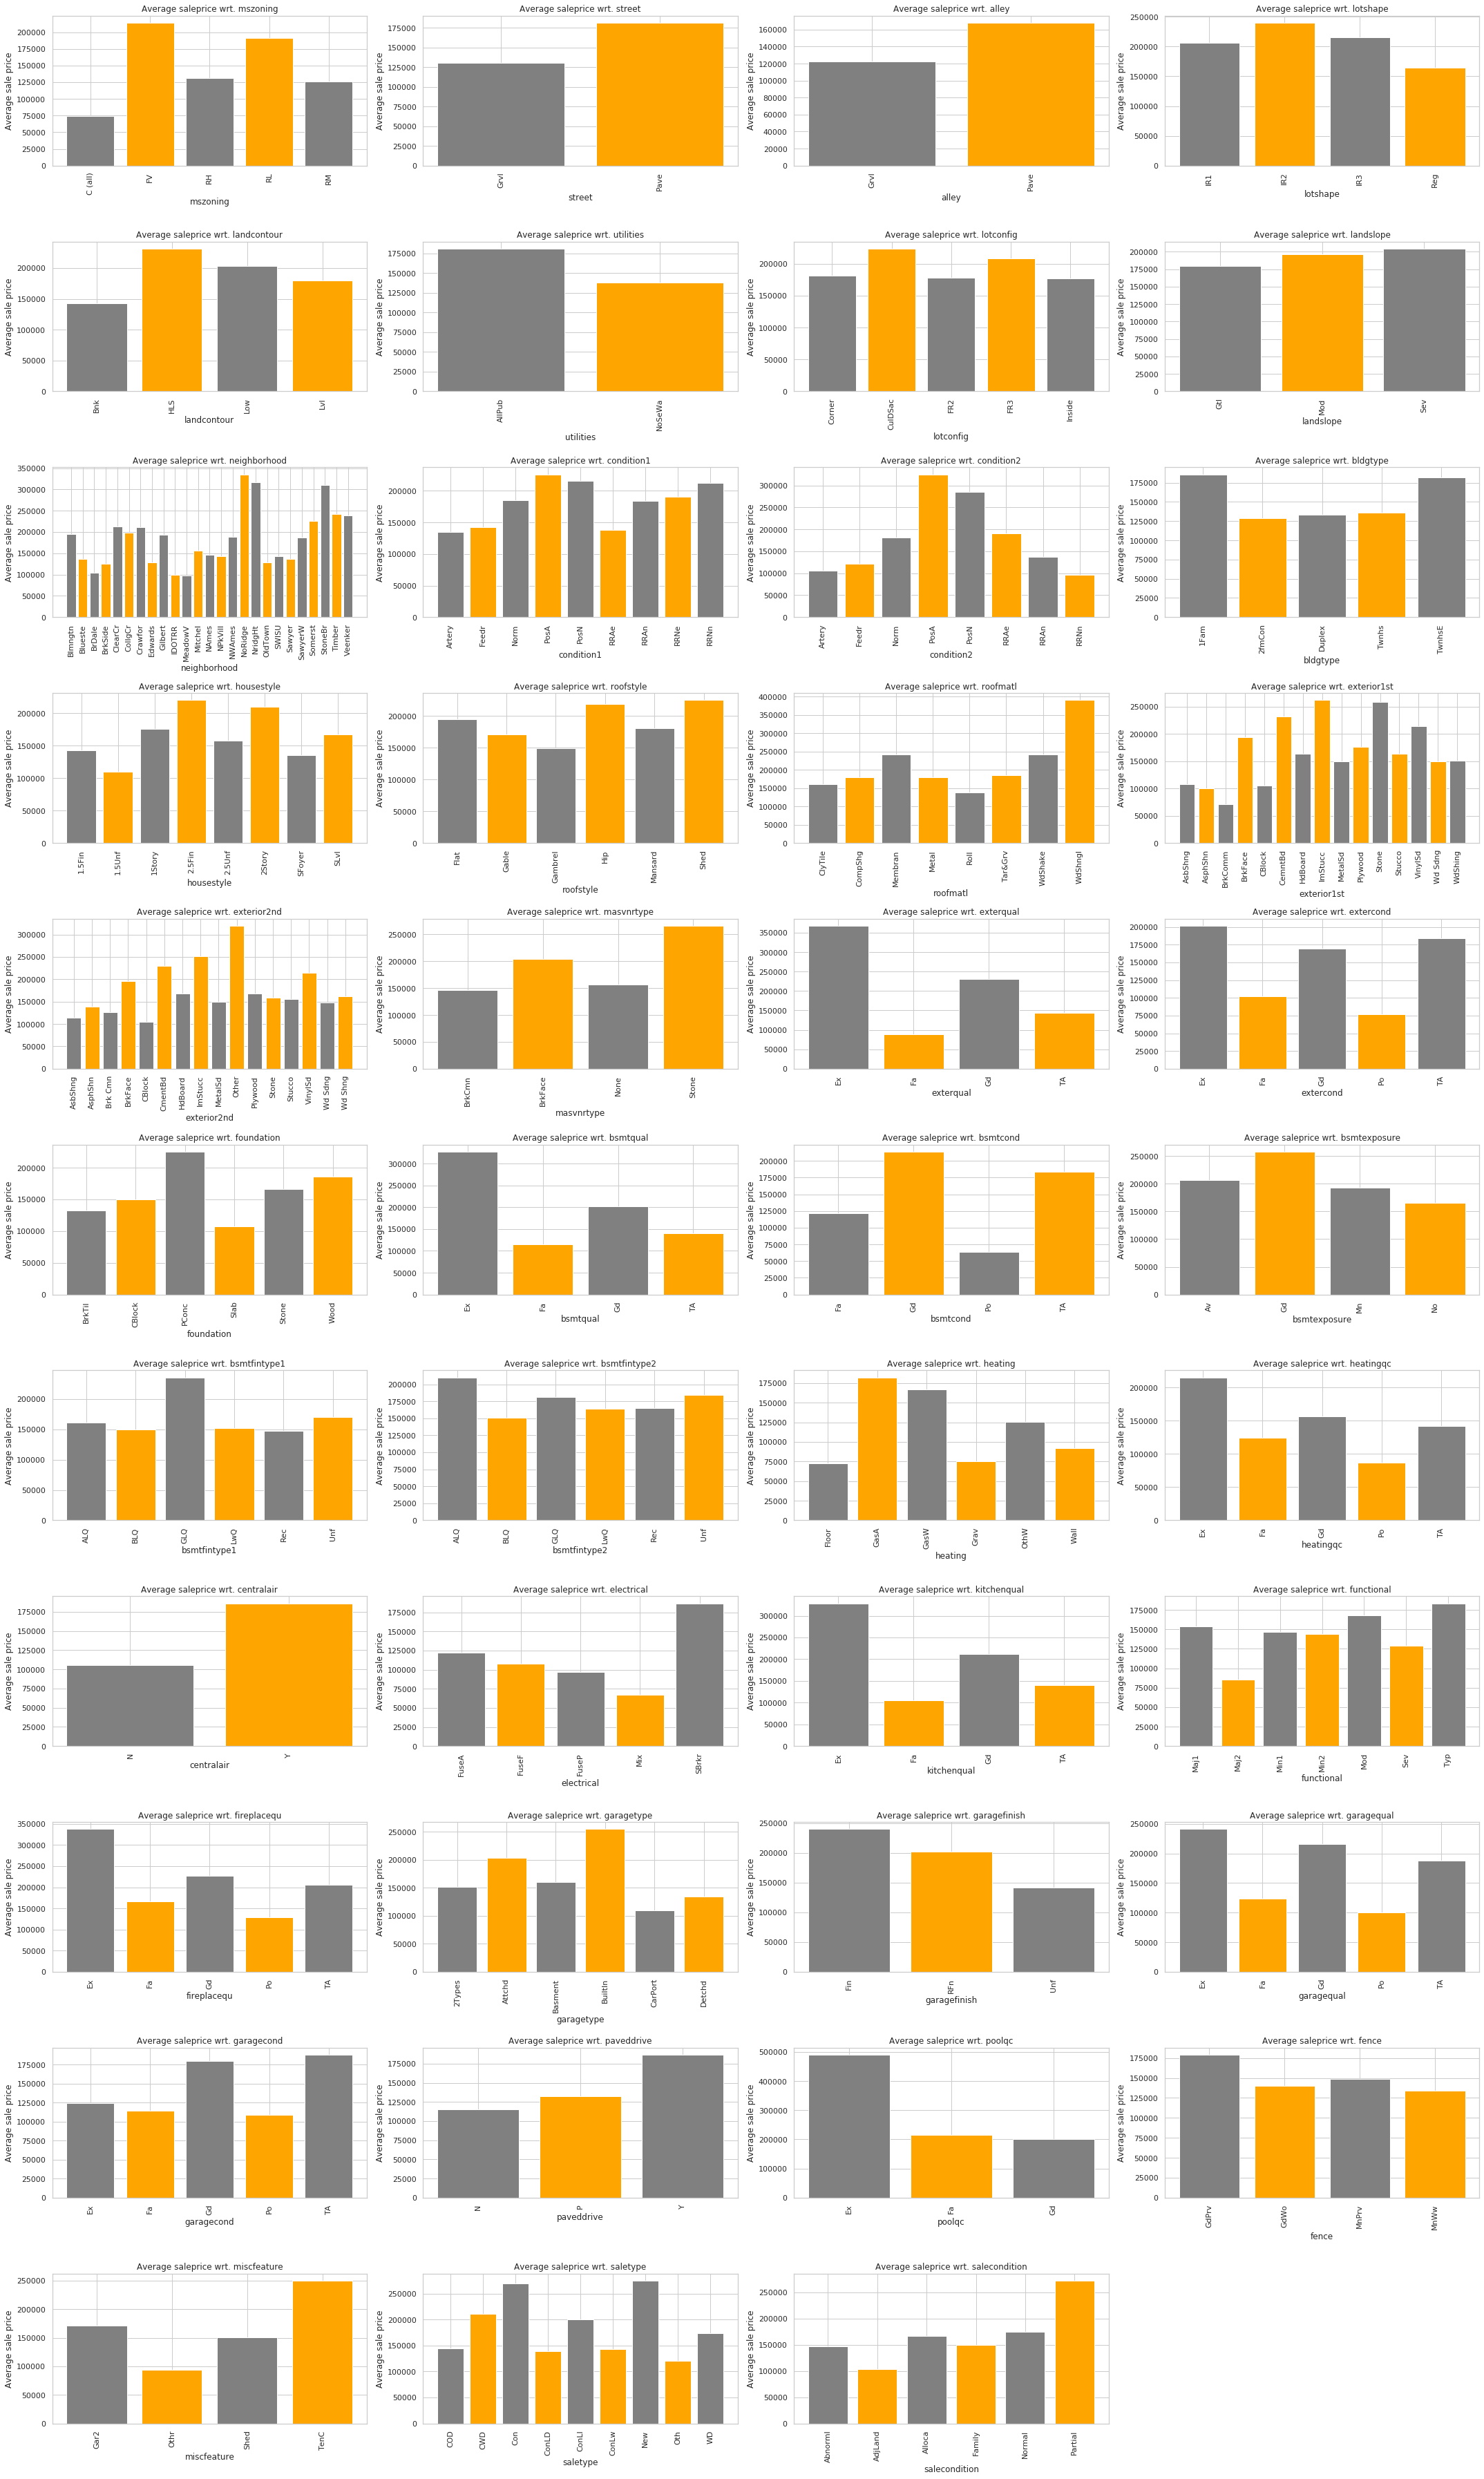

In [17]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(),
           color=("grey","orange"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [0]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [0]:
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_prices_df.saleprice

In [21]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Fri, 21 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:04:12   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.173e+05    1.8e+04     -6.502      0.000   -1.53e+05   -8.19e+04
overallqual  2.333e+04   1088.506     21.430      0.000    2.12e+04    2.55e+04
grlivarea      45.6344      2.468     18.494      0.000      40.794      50.475
garagecars   1.345e+04   2990.453      4.498      0.000    7584.056    1.93e+04
garagearea     16.4082     10.402      1.577      0.115      -3.997      36.813
totalbsmtsf    28.3816      2.931      9.684      0.000      22.633      34.131
mszoning_FV  2.509e+04   1.37e+04      1.833      0.067   -1761.679    5.19e+04
mszoning_RH  1.342e+04   1.58e+04      0.847      0.397   -1.77e+04    4.45e+04
mszoning_RL  2.857e+04   1.27e+04      2.246      0.025    3612.782    5.35e+04
mszoning_RM  9047.7894   1.29e+04      0.702      0.483   -1.62e+04    3.43e+04
street_Pave   151.0376   1.63e+04      0.009      0.993   -3.18e+04    3.21e+04
==============================================================================
Omnibus:                      415.883   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41281.526
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                      29.049   Cond. No.                     5.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""